### Import Dependencies 

In [17]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pathlib
from pathlib import Path 
import shutil
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.models as models

import tensorflow.keras.layers as layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *




In [18]:
shutil.rmtree("/kaggle/working/data_test")
# os.remove("/kaggle/working/conf_matrix_model2_trainable_true.png")

In [19]:
# genre_top_name=os.listdir("/kaggle/input/wikiart")
# genre_top_name.sort(reverse=False)
# genre_top_name.pop()
# genre_top_name.pop()
# genre_top_name=genre_top_name[:3]
# print(genre_top_name)   

In [20]:
artists = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')
# Sort artists by number of paintings
artists_sorted = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
max_artists = artists_sorted[artists_sorted['paintings'] >= 200].reset_index()
max_artists = max_artists[['name', 'paintings']]

#C
max_artists['class_weight'] = max_artists.paintings.sum() / (max_artists.shape[0] * max_artists.paintings)

max_artists



,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


### Organizing folders of train/validation and test

In [21]:
max_artists.replace("Albrecht_Du╠êrer", "Albrecht_Dürer")
max_artists_name = max_artists['name'].str.replace(' ','_').values

print(max_artists_name)

['Vincent_van_Gogh' 'Edgar_Degas' 'Pablo_Picasso' 'Pierre-Auguste_Renoir'
 'Albrecht_Dürer' 'Paul_Gauguin' 'Francisco_Goya' 'Rembrandt'
 'Alfred_Sisley' 'Titian' 'Marc_Chagall']


In [22]:
working_directory = '/kaggle/working/'
# create a new data_training folder with all artists and the files 'train' and 'validation' and data_test folder with all the artists files 'test'
data_training_path = os.path.join(working_directory, 'data_training')
data_test_path = os.path.join(working_directory, 'data_test')
if not os.path.exists(data_training_path):
    os.makedirs(data_training_path)
    print("creation of the folder data_training")

if not os.path.exists(data_test_path):
    os.makedirs(data_test_path)
    print("creation of the folder data_test")

len(max_artists_name)
print(max_artists_name)

train_directory = '/kaggle/working/data_training'
test_directory = '/kaggle/working/data_test'
# create a folder for each artist in data_training and data_test
for i in range(len(max_artists_name)):
    artists_training_path = os.path.join(train_directory, max_artists_name[i])
    artists_test_path = os.path.join(test_directory, max_artists_name[i])
    
    if not os.path.exists(artists_training_path):
        print("creation of the folder", max_artists_name[i])
        os.makedirs(artists_training_path)
    else:
        print("folder", max_artists_name[i], "already exists")
        
    if not os.path.exists(artists_test_path):
        print("creation of the folder", max_artists_name[i])
        os.makedirs(artists_test_path)
    else:
        print("folder", max_artists_name[i], "already exists")
        


for i in range(len(max_artists)):
    path_dataset=   os.path.join( '/kaggle/input/best-artworks-of-all-time/images/images', max_artists_name[i])
    path_working_train= os.path.join(train_directory ,max_artists_name[i])
    path_working_test= os.path.join(test_directory ,max_artists_name[i])

    if (path_dataset=='/kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Dürer'):
        path_dataset='/kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Du╠êrer'

    Dir=os.listdir(path_dataset)
    longueur_train=int(0.9*len(Dir) )
    longueur_test=len(Dir) - longueur_train
    for j in range ( longueur_train):
        shutil.copy(os.path.join(path_dataset,Dir[j]),path_working_train)
    for k in range(longueur_train, longueur_train+longueur_test):
        shutil.copy(os.path.join(path_dataset,Dir[k]),path_working_test)


# '/kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh'
# '/kaggle/working/data_test/Vincent_van_Gogh'
    


['Vincent_van_Gogh' 'Edgar_Degas' 'Pablo_Picasso' 'Pierre-Auguste_Renoir'
 'Albrecht_Dürer' 'Paul_Gauguin' 'Francisco_Goya' 'Rembrandt'
 'Alfred_Sisley' 'Titian' 'Marc_Chagall']
folder Vincent_van_Gogh already exists
folder Vincent_van_Gogh already exists
folder Edgar_Degas already exists
folder Edgar_Degas already exists
folder Pablo_Picasso already exists
folder Pablo_Picasso already exists
folder Pierre-Auguste_Renoir already exists
folder Pierre-Auguste_Renoir already exists
folder Albrecht_Dürer already exists
folder Albrecht_Dürer already exists
folder Paul_Gauguin already exists
folder Paul_Gauguin already exists
folder Francisco_Goya already exists
folder Francisco_Goya already exists
folder Rembrandt already exists
folder Rembrandt already exists
folder Alfred_Sisley already exists
folder Alfred_Sisley already exists
folder Titian already exists
folder Titian already exists
folder Marc_Chagall already exists
folder Marc_Chagall already exists


In [23]:
# working_directory = '/kaggle/working/'
# # create a new data_training folder with all artists and the files 'train' and 'validation' and data_test folder with all the artists files 'test'
# data_training_path = os.path.join(working_directory, 'data_training')
# data_test_path = os.path.join(working_directory, 'data_test')
# if not os.path.exists(data_training_path):
#     os.makedirs(data_training_path)
#     print("creation of the folder data_training")

# # if not os.path.exists(data_test_path):
# #     os.makedirs(data_test_path)
# #     print("creation of the folder data_test")

# train_directory = '/kaggle/working/data_training'
# # test_directory = '/kaggle/working/data_test'

# # create a folder for each genre in data_training and data_test
# for i in range(len(genre_top_name)):
#     artists_training_path = os.path.join(train_directory, genre_top_name[i])
# #     artists_test_path = os.path.join(test_directory, genre_top_name[i])
    
#     if not os.path.exists(artists_training_path):
#         print("creation of the folder", genre_top_name[i])
#         os.makedirs(artists_training_path)
#     else:
#         print("folder", genre_top_name[i], "already exists")
        
# #     if not os.path.exists(artists_test_path):
# #         print("creation of the folder", genre_top_name[i])
# #         os.makedirs(artists_test_path)
# #     else:
# #         print("folder", genre_top_name[i], "already exists")
        

# for i in range(len(genre_top_name)):
#     path_dataset=   os.path.join( '/kaggle/input/wikiart', genre_top_name[i])
#     path_working_train= os.path.join(train_directory ,genre_top_name[i])
# #     path_working_test= os.path.join(test_directory ,genre_top_name[i])

#     Dir=os.listdir(path_dataset)
#     longueur_train=int(1*len(Dir))
#     longueur_test=len(Dir) - longueur_train
#     for j in range (longueur_train):
#         shutil.copy(os.path.join(path_dataset,Dir[j]),path_working_train)
# #    for k in range ( longueur_test):
# #        shutil.copy(os.path.join(path_dataset,Dir[j]),path_working_test)

In [24]:
data_dir = ('/kaggle/working/data_training')
batch_size = 64
train_input_shape = (224,224,3)


train_datagen = ImageDataGenerator(validation_split = 0.2,rescale=1./255.)          

#training dataset
train_generator = train_datagen.flow_from_directory(directory=data_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                   )
#validation dataset
valid_generator = train_datagen.flow_from_directory(directory=data_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3095 images belonging to 11 classes.
Found 769 images belonging to 11 classes.
Total number of batches = 48 and 12


### Visualization of 5 randoms paintings

In [25]:
# # Affichage de 5 peintures aléatoire des artistes selectionnées précédemment avec leur label (genre)


# images_dir = '/kaggle/input/wikiart'

# n = 5
# fig, axes = plt.subplots(1, n, figsize=(20,20))

# for i in range(n):
#     random_genre = random.choice(genre_top_name)
#     random_image = random.choice(os.listdir(os.path.join(images_dir, random_genre)))
#     random_image_file = os.path.join(images_dir, random_genre, random_image)
#     image = plt.imread(random_image_file)
#     axes[i].imshow(image)
#     axes[i].set_title("Genre: " + random_genre.replace('_',' '))
#     axes[i].axis('off')

# plt.show()

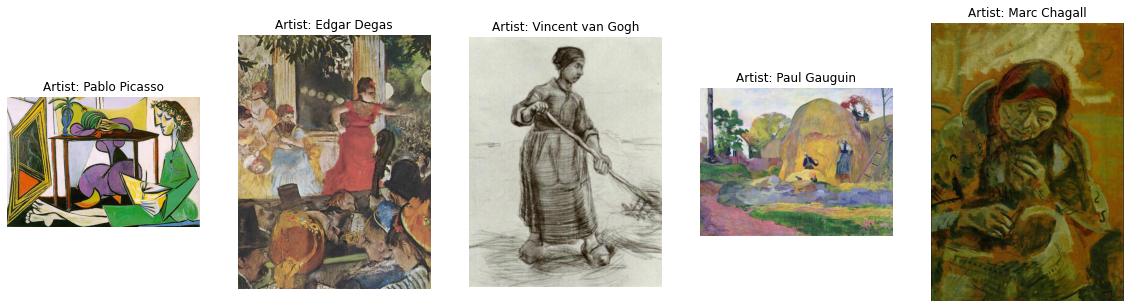

In [26]:
# Affichage de 5 peintures aléatoire des artistes selectionnées précédemment avec leur label (artiste)

max_artists.replace("Albrecht_Du╠êrer", "Albrecht_Dürer")
max_artists_name = max_artists['name'].str.replace(' ', '_').values
# Explore images of top artists
images_dir = '/kaggle/input/best-artworks-of-all-time/images/images'

n = 5
fig, axes = plt.subplots(1, n, figsize=(20,20))

for i in range(n):
    random_artist = random.choice(max_artists_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_',' '))
    axes[i].axis('off')

plt.show()

### Implementation of CNN

In [27]:
print(train_input_shape)

(224, 224, 3)


In [44]:
input_shape = train_input_shape
n_classes = len(max_artists_name)

#Create model
# model = models.Sequential()

# #Add input layer
# model.add(layers.Input(shape=input_shape))

# # Add convolutional layers
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# # Add fully connected layers
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(512, activation='relu'))

# # Add output layer
# model.add(layers.Dense(n_classes, activation='softmax'))


# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
# input_shape=(img_height, img_width, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(len(artists_top_name), activation='sigmoid'))
# model = tf.keras.Sequential([
#     layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(224, 224, 3)),
#     # 2x2 Maxpool
#     layers.MaxPooling2D(),
#     # 3x3 CONV, stride 2, padding 1
#     layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
#     # 2x2 Maxpool
#     layers.MaxPooling2D(),
#     # Flatten the output of the convolutional layers
#     layers.Flatten(),
#     # 1x6272 Fully-connected
#     layers.Dense(6272, activation='relu'),
#     # 1x228 Fully-connected
#     layers.Dense(228, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     layers.Dense(n_classes, activation='softmax')
# ])


inputs = tf.keras.Input(shape=input_shape)
#Loading the ResNet50 model with pre-trained ImageNet weights
resnet = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=inputs)

for layer in resnet.layers[:170]:
   layer.trainable = True

inputs = tf.keras.Input(shape=input_shape)

model = tf.keras.models.Sequential()
model.add(resnet)
model.add(tf.keras.layers.Flatten())
model.add( tf.keras.layers.Dense(n_classes, activation='softmax'))


In [45]:
# optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [46]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
#                               verbose=1, mode='auto')

In [47]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = max_artists['class_weight'].to_dict()
class_weights
print(class_weights)

{0: 0.44563076604125634, 1: 0.5567210567210568, 2: 0.8902464278318493, 3: 1.1631493506493507, 4: 1.1915188470066518, 5: 1.2566501023092662, 6: 1.3430178069353327, 7: 1.491672449687717, 8: 1.5089505089505089, 9: 1.532620320855615, 10: 1.6352225180677062}


In [48]:
# Define a checkpoint callback
checkpoint_callback = ModelCheckpoint(
    '/kaggle/working/model.h5', # filepath
    monitor='val_accuracy', # metric to monitor
    mode='max', # mode: max, min, or auto
    save_best_only=True, # save only the best model
    save_weights_only=False, # save the entire model
    verbose=1)

In [49]:
# Train the model - all layers
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks = [checkpoint_callback],
                              use_multiprocessing=True,
                              workers=8,
#                               class_weight = class_weights
                             )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
48/48 [==============================] - 92s 2s/step - loss: 4.7882 - accuracy: 0.4022 - val_loss: 34600432.0000 - val_accuracy: 0.0612

Epoch 00001: val_accuracy improved from -inf to 0.06120, saving model to /kaggle/working/model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
48/48 [==============================] - 75s 1s/step - loss: 1.6805 - accuracy: 0.6077 - val_loss: 9044.1172 - val_accuracy: 0.0625

Epoch 00002: val_accuracy improved from 0.06120 to 0.06250, saving model to /kaggle/working/model.h5
Epoch 3/20
48/48 [==============================] - 80s 1s/step - loss: 1.2916 - accuracy: 0.7149 - val_loss: 2.4176 - val_accuracy: 0.2031

Epoch 00003: val_accuracy improved from 0.06250 to 0.20312, saving model to /kaggle/working/model.h5
Epoch 4/20
48/48 [==============================] - 74s 1s/step - loss: 0.9926 - accuracy: 0.7981 - val_loss: 2.6655 - val_accuracy: 0.0677

Epoch 00004: val_accuracy did not improve from 0.20312
Epoch 5/20
48/48 [==============================] - 73s 1s/step - loss: 1.6883 - accuracy: 0.7285 - val_loss: 2.5145 - val_accuracy: 0.0677

Epoch 00005: val_accuracy did not improve from 0.20312
Epoch 6/20
48/48 [==============================] - 81s 1s/step - loss: 1.6645 - accuracy: 0.7377 - val_loss: 2.8595 - va

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1103883   
Total params: 24,691,595
Trainable params: 24,638,475
Non-trainable params: 53,120
_________________________________________________________________


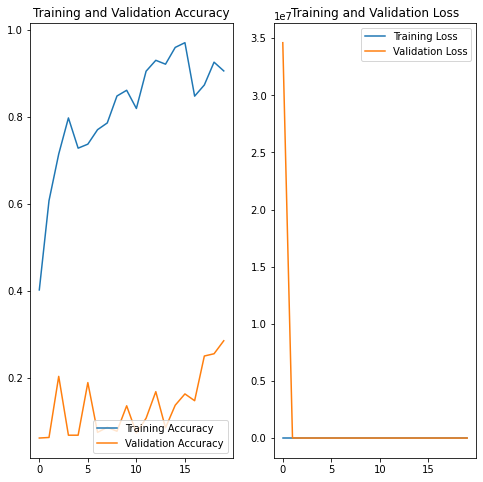

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
valid_generator.class_indices
class_names = {valid_generator.class_indices[i]:i for i in valid_generator.class_indices}


In [53]:
#Generating Test batch
test_dir = ('/kaggle/working/data_training')
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=True
                                                   )
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print("Total number of batches in test set =", STEP_SIZE_TEST)



Found 3864 images belonging to 11 classes.
Total number of batches in test set = 60


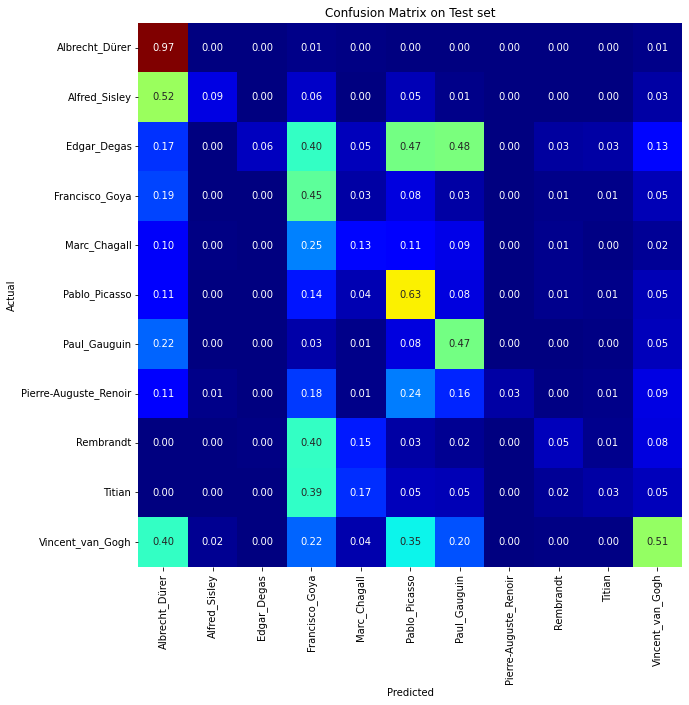

Classification Report on Test set:
                       precision    recall  f1-score   support

       Albrecht_Dürer       0.35      0.97      0.51       294
        Alfred_Sisley       0.74      0.09      0.15       233
          Edgar_Degas       0.78      0.06      0.10       631
       Francisco_Goya       0.18      0.45      0.25       261
         Marc_Chagall       0.20      0.13      0.16       211
        Pablo_Picasso       0.30      0.63      0.41       390
         Paul_Gauguin       0.30      0.47      0.37       279
Pierre-Auguste_Renoir       0.91      0.03      0.06       301
            Rembrandt       0.35      0.05      0.09       234
               Titian       0.27      0.03      0.06       226
     Vincent_van_Gogh       0.48      0.51      0.49       780

             accuracy                           0.34      3840
            macro avg       0.44      0.31      0.24      3840
         weighted avg       0.48      0.34      0.27      3840



In [54]:
def showClassficationReport_Test(model, test_generator, STEP_SIZE_TEST):
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_TEST):
        (X,y) = next(test_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
        
    tick_labels = [class_names[i] for i in range(len(class_names))]
    
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix on Test set')
    plt.savefig('conf_matrix_model2_trainable_true.png')
    plt.show()
    
    print('Classification Report on Test set:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=tick_labels))
    
showClassficationReport_Test(model, test_generator, STEP_SIZE_TEST)